# Test model on data

Here we examine the performance of our model on a test dataset.  This dataset contains no games previously seen by the model, and has an even distribution of ratings between 1000-2600 ELO.  We first need to load our dataset, then we can start to examine our results

In [55]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sklearn as sk
from sklearn.model_selection import train_test_split
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [56]:
Model_test_Dataset = pd.read_csv('Test Data\\Curated_Test_Data.csv')
Dataset_list = [Model_test_Dataset]

In [57]:
def Feature_Label_Extraction(df_in,num_of_examples = 4200):
    df_out = df_in[0:num_of_examples]
    df_out_feature = df_out.iloc[:,:832]
    
    white_elos = df_out["White ELO"].astype(int)
    black_elos = df_out["Black ELO"].astype(int)
    avg_elos = np.mean([np.array(white_elos),np.array(black_elos)],axis=0)
    
    df_out_label = pd.DataFrame(columns = ["Average ELO"])
    df_out_label["Average ELO"] = avg_elos
    
    #df_out_label = white_elos
    return df_out_feature , df_out_label
    
def Prepare_Datasets(dataset_list):
    out_df_feature = pd.DataFrame()
    out_df_label = pd.DataFrame()
    for dataframe in dataset_list:
        feature , label = Feature_Label_Extraction(dataframe)
        out_df_feature = out_df_feature.append(feature,ignore_index=True)
        #out_df_label = out_df_label.append(label,ignore_index = True)
        out_df_label = pd.concat([out_df_label,label])
    return out_df_feature , out_df_label


def Hot_1_encoder(df_in):
    New_array = np.zeros([df_in.shape[0],df_in.shape[1]*13])
    for i in range(df_in.shape[0]):
        for j,val in enumerate(df_in.iloc[i][:]):
            New_array[i,13*j+int(val)] = 1
            
    return New_array

In [58]:
trainx, trainy = Prepare_Datasets(Dataset_list)

In [61]:
#Load our model and make predictions
Test_model = keras.models.load_model('Model')
x_pred = Test_model.predict_on_batch(trainx)*1599 + 1000
x_pred = x_pred.flatten().tolist()

Now that we have made our predictions on our test dataset, we can see how we've done.

Text(0.5, 1.0, 'True ELO value compared to predicted ELO value')

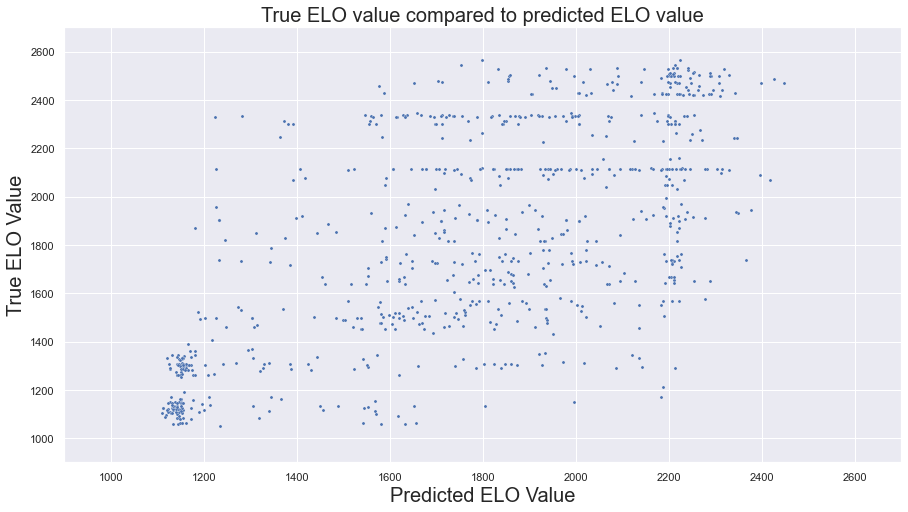

In [121]:
plot_dict = {
    'x' : x_pred,
    'y' : trainy.values.flatten()
}
plot =sns.scatterplot(x = 'x',y = 'y',data = plot_dict, s=10)
plot.set_xlim(900,2700)
plot.set_xlabel('Predicted ELO Value',fontsize = 20)
plot.set_ylim(900,2700)
plot.set_ylabel('True ELO Value',fontsize = 20)
plot.set_title('True ELO value compared to predicted ELO value',fontsize = 20)
#plot.figsize = (1,1)

A perfect classifier would find a straight line connecting the bottom left and upper right corners of the plot, but predictably we fall short of perfection.  However, we can see that there are some clusters forming.  Generally, the point density near this 'perfect classifier' line is higher than it is when farther away.  However, this is very difficult to see by looking at the data in this form.  We can do better.

In [122]:
pred_real = list(zip(trainy.transpose()[0],x_pred))

In [123]:
def Build_Brackets(real_elo):
    bracket_dict = {
        0 : '1000-1199',
        1 : '1200-1399',
        2 : '1400-1599',
        3 : '1600-1799',
        4 : '1800-1999', 
        5 : '2000-2199',
        6 : '2200-2399',
        7 : '2400-2599',
        8 : '2600 +'
        }
    key = (int(real_elo)-1000)//200
    return bracket_dict.get(key)

In [125]:
pred_real_df = pd.DataFrame()
pred_real_df["Real ELO"] = trainy["Average ELO"]
pred_real_df["Predicted ELO"] = x_pred
pred_real_df["ELO Bracket"] = trainy["Average ELO"].astype(int).apply(lambda x:Build_Brackets(x))
pred_real_df["Pred ELO Bracket"] = [Build_Brackets(i) for i in x_pred]

We can bin our data to make this analysis easier.  Because the data has been processed by averaging the ELO value of two similarly valued players, each of which must be within a particular ELO bracket, the size and location of our bins is natural.

In [126]:
Predictions = pd.DataFrame()
Pred_only = pd.DataFrame()
True_only = pd.DataFrame()
ELO_bracket = ['1000-1199','1200-1399','1400-1599','1600-1799','1800-1999','2000-2199','2200-2399']
ELO_bracket_num = [[1000,1199],[1200,1399],[1400,1599],[1600,1799],[1800,1999],[2000,2199],[2200,2399]]
Pred_dict = dict()
for i in range(len(ELO_bracket)):
    Predictions['true ELO ' + ELO_bracket[i]] = pred_real_df["Real ELO"][(pred_real_df["Real ELO"]>ELO_bracket_num[i][0]) & 
                                                                         (pred_real_df["Real ELO"]<ELO_bracket_num[i][1])]
    Predictions['pred ELO ' + ELO_bracket[i]] = pred_real_df["Predicted ELO"][(pred_real_df["Real ELO"]>ELO_bracket_num[i][0]) & 
                                                            (pred_real_df["Real ELO"]<ELO_bracket_num[i][1])]
    Pred_only['pred ELO ' + ELO_bracket[i]] =  pred_real_df["Predicted ELO"][(pred_real_df["Real ELO"]>ELO_bracket_num[i][0]) & 
                                                            (pred_real_df["Real ELO"]<ELO_bracket_num[i][1])]
    True_only['true ELO ' + ELO_bracket[i]] = pred_real_df["Real ELO"][(pred_real_df["Real ELO"]>ELO_bracket_num[i][0]) & 
                                                                         (pred_real_df["Real ELO"]<ELO_bracket_num[i][1])]
    
    Pred_dict[ELO_bracket[i]] = pred_real_df[(pred_real_df["Real ELO"]>ELO_bracket_num[i][0]) & (pred_real_df["Real ELO"]<ELO_bracket_num[i][1])]

In [127]:
test =  pred_real_df[(pred_real_df["Real ELO"]>ELO_bracket_num[0][0]) & (pred_real_df["Real ELO"]<ELO_bracket_num[0][1])]

Text(0.5, 1.0, 'Predicted ELO by bracket')

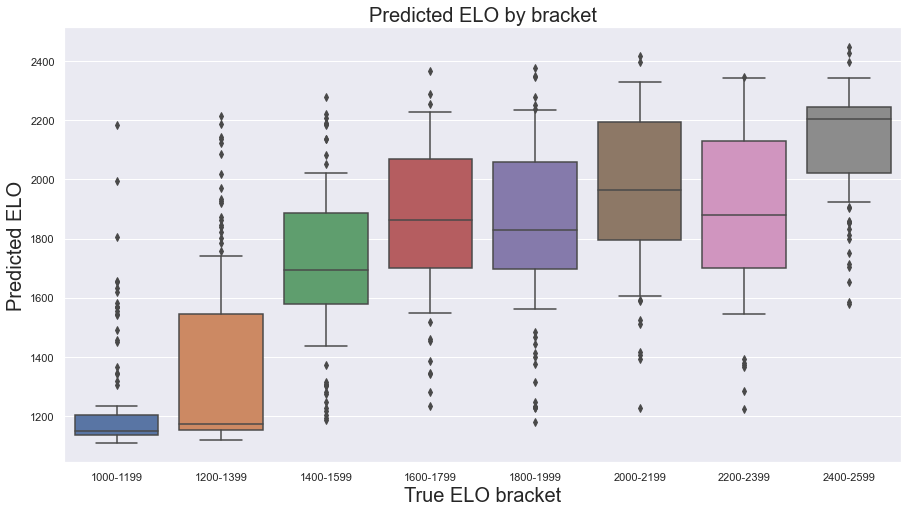

In [131]:
x = list(Pred_dict.keys())
box_plt = sns.boxplot(x = "ELO Bracket", 
                 y = "Predicted ELO",
                 data = pred_real_df.sort_values(by = ["ELO Bracket"]), 
                 whis = 0.5)
box_plt.set_ylabel('Predicted ELO', fontsize=20)
box_plt.set_xlabel('True ELO bracket', fontsize=20)
box_plt.set_title('Predicted ELO by bracket', fontsize=20)

This figure is similar to the previous one but instead of using a scatterplot we have binned our data and drawn a box and whisker plot to more clearly show the trend.  As the true ELO value of the players increases, so does the predicted ELO value, with a few exceptions.  There seems to be an effect where we see a great deal of separation between the lowest ELO bracket and ELO values of 1800 or more.  It seems as though the model can determine if you're a good player or a bad player, but when you're very good, it can't quite resolve the difference.

Though the box and whisker plot is hlepful, I think it's also helpful to evaluate our data in terms of an ROC curve.  However, ROC plots are typically used to evaluate binary classifiers.  We are using regression, which makes this type of evaluation difficult.  I've developed a plot which demonstrates the effectiveness of our classification with a continuous dataype while borrowing the helpful visual language of the familiar ROC plot.  This plot measures the fraction of predictions which fall within a particular range of their true value.  Similar to an ROC plot, a nearly straight line would be a random guess, while curve that reaches toward the top left of the plot would be a perfect classifier.

In [132]:
def ROCgression(real_vals,pred_vals):
    real = np.array(real_vals,dtype=int)
    pred = np.array(pred_vals,dtype=int)
    difference = abs(real-pred)
    
    
    ROC_curve = np.zeros(max(difference)+1)
    
    for i in difference:
        ROC_curve[i] += 1
        
    for i in range(1,len(ROC_curve)):
        ROC_curve[i] += ROC_curve[i-1]
        
    ROC_curve = np.divide(ROC_curve,len(difference))
    
    return ROC_curve

In [133]:
random_array = np.random.randint(pred_real_df["Real ELO"].min(),
                          high = pred_real_df["Real ELO"].max(),
                         size = np.shape(pred_real_df["Real ELO"]))

In [134]:
Model_ROC = ROCgression(pred_real_df["Real ELO"],pred_real_df["Predicted ELO"])
Random_ROC = ROCgression(pred_real_df["Real ELO"],random_array)

In [135]:
ROC_dict = {'Model_ROC': Model_ROC,
           'Random_Roc': Random_ROC}

Text(0, 0.5, 'Fraction of Dataset')

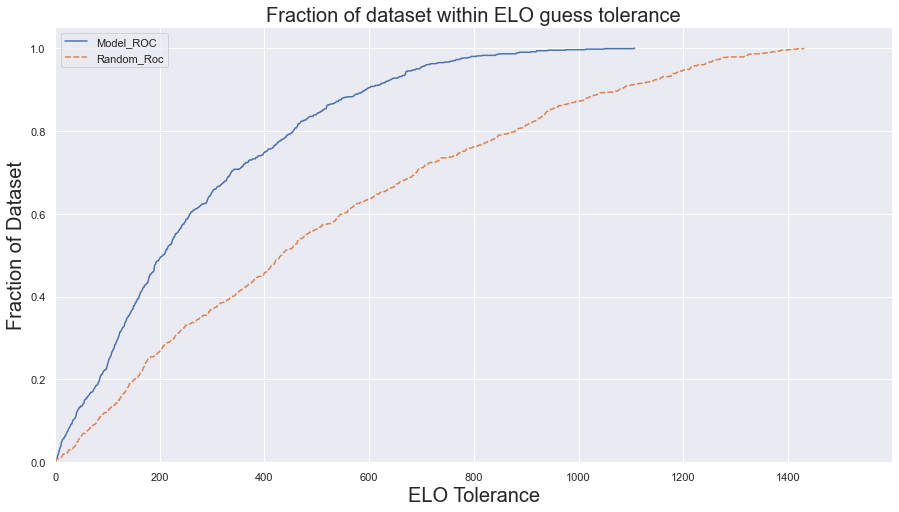

In [137]:
ax = sns.lineplot(data = ROC_dict)
ax.set_xlim([0,1599])
ax.set_ylim([0,1.05])
ax.set_title('Fraction of dataset within ELO guess tolerance',fontsize = 20)
ax.set_xlabel('ELO Tolerance',fontsize = 20)
ax.set_ylabel('Fraction of Dataset',fontsize = 20)

Here we can see that our model is superior to the random classifier, with 50% of the model predictions falling within approximately 200 ELO of their true value.  This is a significant improvement to the random guess, in which the true value falls within approximately 425 ELO.  

This is a useful metric to get a sense of how effective our model is when guessing the true skill of players in a game, but we can extend this idea further by reintroducing the bins we developed in the previous section.  Clearly our model works better for some skill levels than others, where the very highly skilled players are very difficult for our model to differentiate between them.

In [51]:
ROC_Classified_Dict = {}
for label in pred_real_df["ELO Bracket"].unique():
    sliced = pred_real_df.loc[pred_real_df["ELO Bracket"] == label]
    ROC_Classified_Dict[label] = ROCgression(sliced["Real ELO"],sliced["Predicted ELO"])
    
ROC_Classified_Dict["Random Guess"] = ROC_dict["Random_Roc"]

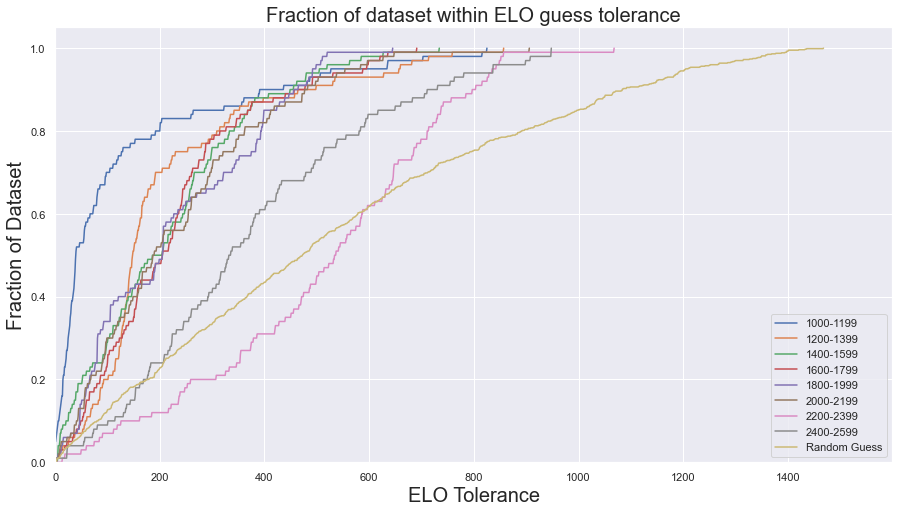

In [140]:
ax = sns.lineplot(data = ROC_Classified_Dict,dashes=False)
ax.set_xlim([0,1599])
ax.set_ylim([0,1.05])
ax.set_title('Fraction of dataset within ELO guess tolerance',fontsize = 20)
ax.set_xlabel('ELO Tolerance',fontsize = 20)
ax.set_ylabel('Fraction of Dataset',fontsize = 20)
ax.legend(loc='lower right')

The above plot reproduces our ROC curve, with the different ELO brackets of players broken down by color.  We can see that for lower skilled players (the blue and orange curve) the model performs exceptionally well, with 50% of the predictions falling within 50-150 ELO respectively.

This is can be contrasted with the pink and grey curves, which either perform scarcely better than a random guess or worse.  Here our model lacks discriminatory power.  At this level of play, it's possible that we need more than one board position to classify a player.  The positions amongst the highest levels of play may be similar, but are separated by the quality of the decision making of the players in particular positions.

In [53]:
ROC_Pred_Classified_Dict = {}
for label in pred_real_df["Pred ELO Bracket"].unique():
    sliced = pred_real_df.loc[pred_real_df["Pred ELO Bracket"] == label]
    ROC_Pred_Classified_Dict[label] = ROCgression(sliced["Real ELO"],sliced["Predicted ELO"])
    #print(len(sliced),label)
    #if len(sliced) < 10:
    #    print('popping')
    #    ROC_Pred_Classified_Dict.pop(label)
    
ROC_Pred_Classified_Dict["Random Guess"] = ROC_dict["Random_Roc"]

This plot is in some ways more useful than the previous, while representing very similar data.  The previous ROC plot broken up by data bracket.  However, the previous plot was a representation of how close the predicted ELO value is to the true value given the true value.  That is, P(model prediction|true value).  However, this is not a circumstance we will encounter often.  It's much more useful to calculate P(true value|model prediction)

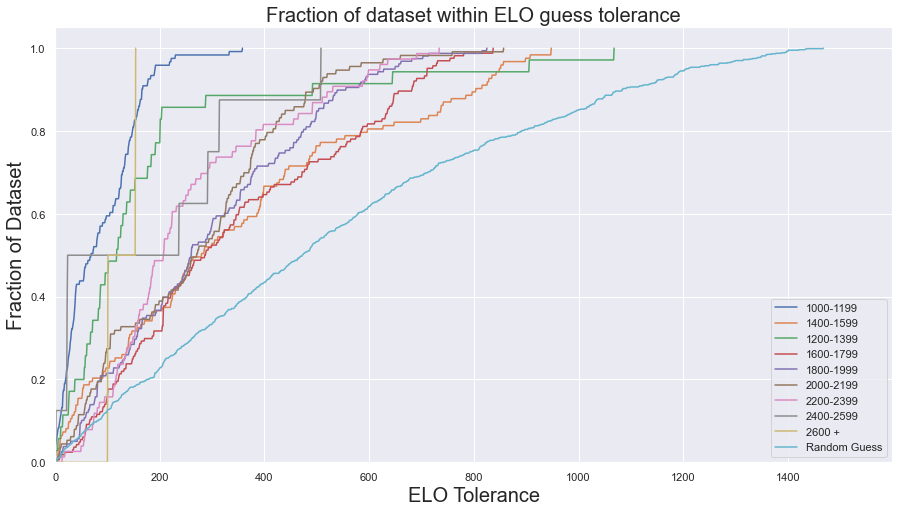

In [141]:
ax = sns.lineplot(data = ROC_Pred_Classified_Dict,dashes=False)
ax.set_xlim([0,1599])
ax.set_ylim([0,1.05])
ax.set_title('Fraction of dataset within ELO guess tolerance',fontsize = 20)
ax.set_xlabel('ELO Tolerance',fontsize = 20)
ax.set_ylabel('Fraction of Dataset',fontsize = 20)
ax.legend(loc='lower right')

In [ ]:
def MSE(pred_df,true_df):
    MSE_list = []
    total_SE = 0
    count = 0
    pred_cols = list(pred_df.columns)
    true_cols = list(true_df.columns)
    
    for i in range(len(pred_cols)):
        SE = 0
        for j in range(len(pred_df.loc[:,pred_cols[i]])):
            SE += (pred_df.loc[j,pred_cols[i]] - true_df.loc[j,true_cols[i]])**2
            count += 1
        MSE_list .append(np.sqrt(SE/len(pred_df.loc[:,pred_cols[i]])))
        total_SE += SE
    total_MSE = total_SE/count
    
    return MSE_list , total_MSE